In [1]:
import glob
import os.path

from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

from scipy.ndimage import median_filter

from sklearn import ensemble, neural_network
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Predict power load using temperature

In [2]:
# Use this for larger plots:
#matplotlib.rc('figure', figsize=(15, 10))
matplotlib.rc('figure', figsize=(10, 8))

In [3]:
COUNTRIES = 'Austria', 'Germany', 'Switzerland', 'Italy', 'Spain', 'Sweden', 'United Kingdom'

In [4]:
CONFIG_FILE = '../entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [5]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    
    print("Files read, concatenating to dataframe...")
    data = pd.concat(each_csv_file, ignore_index=True)
    
    print("Sorting and indexing...")
    data = data.set_index("DateTime")
    data.sort_index(inplace=True)
    
    # filter only for countries under consideration to make things faster and consume less RAM...
    data_ = data[data.AreaName.isin(COUNTRIES)].copy()
    del data
    data = data_
    
    print("Resampling...")
    data = data.groupby('AreaName').resample("1h").mean()
    
    # we should end up with a dataframe with DateTime as index, AreaName as columns
    # and Total load as entries...
    print("Reshaping dataframe...")
    data = data.TotalLoadValue.unstack(level=0).interpolate()
    
    print("Loading done.")

    return data


# note: this might require 3GB of RAM

power_demand = load_complete_entso_e_data(download_dir)

Concatenating 69 csv files...
Files read, concatenating to dataframe...
Sorting and indexing...
Resampling...
Reshaping dataframe...
Loading done.


In [6]:
power_train = power_demand.Austria['2016-01-01':'2018-12-31']
power_test  = power_demand.Austria['2019-01-01':'2019-12-31']

### Random forests with features dayofyear/hour/weekday

In [7]:
def get_fetures(data):
    dayofyear = data.index.dayofyear.values[:, np.newaxis]
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((dayofyear, hour, weekday), axis=1)

In [8]:
X_train = get_fetures(power_train)
X_test = get_fetures(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [9]:
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [10]:
forest.score(X_test, Y_test)

0.8929736882251821

### Can we improve residuals with using temperature?

In [11]:
temperature = xr.load_dataset("../data/temperatures_era5.nc").t2m.sel(longitude=16.5, latitude=48)

In [12]:
def mean_temperature_dayofyear(temperature, time):
    temperature_interpolated = temperature.interp(time=time)
    return temperature_interpolated.groupby(temperature_interpolated.time.dt.dayofyear).mean()

In [13]:
temperature_train = mean_temperature_dayofyear(temperature=temperature, time=power_train.index)
temperature_test = mean_temperature_dayofyear(temperature=temperature, time=power_test.index)

In [14]:
residuals = pd.Series(Y_test - forest.predict(X_test), index=power_test.index)

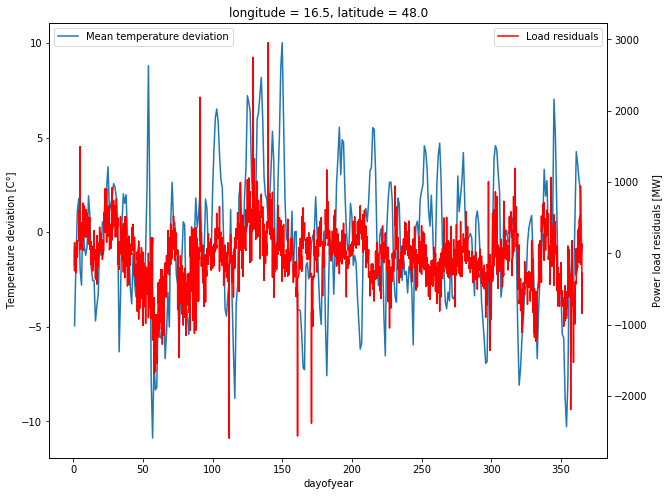

In [15]:
(temperature_train - temperature_test).plot.line(label='Mean temperature deviation')
plt.legend(loc='upper left')
plt.ylabel('Temperature deviation [C°]')
ax2 = plt.gca().twinx()
ax2.plot(power_test.index.dayofyear, residuals, 'r-', label='Load residuals')
plt.ylabel('Power load residuals [MW]')
plt.legend()

Text(0.5, 0, 'Temperature deviation [C°]')

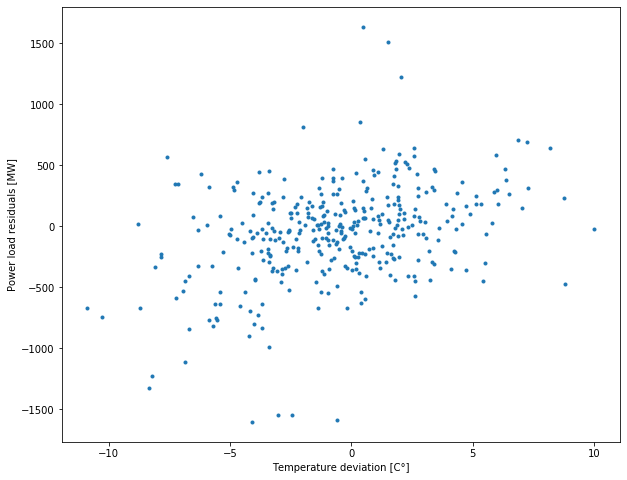

In [16]:
plt.plot(temperature_train - temperature_test,
         residuals.groupby(residuals.index.dayofyear).mean(), 'o', markersize=3)
plt.ylabel('Power load residuals [MW]')
plt.xlabel('Temperature deviation [C°]')

Okay, not sure if there is a lot of dependence here. Let's try it out!

In [17]:
def get_fetures(data, temperature):
    dayofyear = data.index.dayofyear.values[:, np.newaxis]
    week = data.index.week.values[:, np.newaxis]
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((dayofyear, week, hour, weekday, temperature.values[:, np.newaxis]), axis=1)

In [18]:
X_train = get_fetures(power_train, temperature.interp(time=power_train.index))
X_test = get_fetures(power_test, temperature.interp(time=power_test.index))
Y_train = power_train.values
Y_test = power_test.values

In [19]:
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
forest.score(X_test, Y_test)

0.9338961424717278

In [21]:
Y_predict = forest.predict(X_test)

Compare our model with the poor-man-method using weekly averages only:

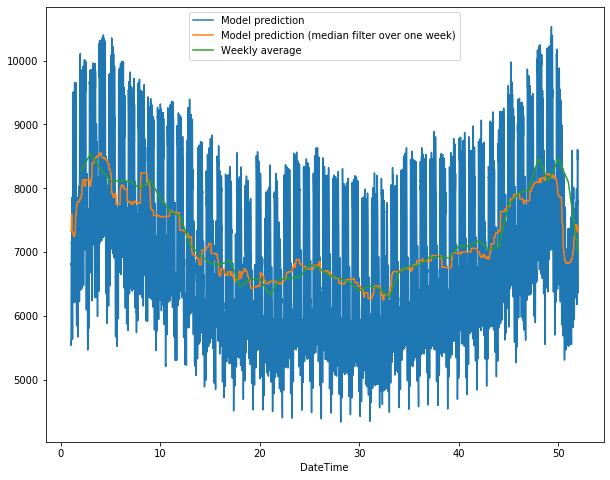

In [22]:
plt.plot(np.linspace(1, 52, num=8760), Y_predict, label='Model prediction')
plt.plot(np.linspace(1, 52, num=8760), median_filter(Y_predict, size=7*24), label='Model prediction (median filter over one week)')
power_train.groupby(power_train.index.week).mean()[1:-1].plot.line(label='Weekly average')

plt.legend();

### Random forests with features week of year/hour/weekday

In [23]:
def get_fetures(data):
    week = data.index.week.values[:, np.newaxis]
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((week, hour, weekday), axis=1)

In [24]:
X_train = get_fetures(power_train)
X_test = get_fetures(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [25]:
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [26]:
forest.score(X_test, Y_test)

0.8994820584082757

### Linear regression with dummies with features dayofyear/hour/weekday

In [27]:
def get_dummies(data):
    dayofyear = pd.get_dummies(pd.Categorical(data.index.dayofyear, categories=np.arange(1,367)))
    hour = pd.get_dummies(data.index.hour)
    weekday = pd.get_dummies(data.index.weekday)
    return np.concatenate((dayofyear, hour, weekday), axis=1)

In [28]:
X_train = get_dummies(power_train)
X_test = get_dummies(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [29]:
forest = LinearRegression()
forest.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
forest.score(X_test, Y_test)

0.8580713500177406

### Linear regression with dummies with features month/hour/weekday

In [31]:
def get_dummies(data):
    month = pd.get_dummies(data.index.month)
    hour = pd.get_dummies(data.index.hour)
    weekday = pd.get_dummies(data.index.weekday)
    return np.concatenate((month, hour, weekday), axis=1)

In [32]:
X_train = get_dummies(power_train)
X_test = get_dummies(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [33]:
forest = LinearRegression()
forest.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
forest.score(X_test, Y_test)

0.8253180803001711

### Random forests with features month/hour/weekday

In [35]:
def get_fetures(data):
    month = data.index.month.values[:, np.newaxis]
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((month, hour, weekday), axis=1)

In [36]:
X_train = get_fetures(power_train)
X_test = get_fetures(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [37]:
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [38]:
forest.score(X_test, Y_test)

0.8780688553692713

### Can we increase R2 score by reducing size feature space?

Let's do something in between week of year and day of year, by putting consecutive days into bins of a certain size. `binsize=1` would be equivalent to dayofyear and 7 would be very similar to week of year (except first and last week of the year).

In [39]:
def get_fetures(data, binsize=1):
    bin_ = data.index.dayofyear.values[:, np.newaxis]
    bin_ = np.floor(bin_ / binsize).astype(np.int)
    
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((bin_, hour, weekday), axis=1)

In [40]:
scores = []

for binsize in np.arange(1, 150):
    X_train = get_fetures(power_train, binsize=binsize)
    X_test = get_fetures(power_test, binsize=binsize)
    Y_train = power_trainmean_filter.values
    Y_test = power_test.values

    forest = ensemble.RandomForestRegressor()
    forest.fit(X_train, Y_train)

    scores.append(forest.score(X_test, Y_test))
    print("binsize = ", binsize, "R2 test score = ", scores[-1])

binsize =  1 R2 test score =  0.8937216274703221
binsize =  2 R2 test score =  0.8830010926137063
binsize =  3 R2 test score =  0.8958702423678853
binsize =  4 R2 test score =  0.876250345953235
binsize =  5 R2 test score =  0.877939955968656
binsize =  6 R2 test score =  0.8869035748671069
binsize =  7 R2 test score =  0.901012745094027
binsize =  8 R2 test score =  0.8896352902830194
binsize =  9 R2 test score =  0.896130773515187
binsize =  10 R2 test score =  0.8893968241678718
binsize =  11 R2 test score =  0.9003069975872331
binsize =  12 R2 test score =  0.8861808119275246
binsize =  13 R2 test score =  0.8989594222613445
binsize =  14 R2 test score =  0.8966756611728977
binsize =  15 R2 test score =  0.8931140072689511
binsize =  16 R2 test score =  0.8995912888226067
binsize =  17 R2 test score =  0.904482330682904
binsize =  18 R2 test score =  0.8910894882644476
binsize =  19 R2 test score =  0.8858537650445022
binsize =  20 R2 test score =  0.8849864210730457
binsize =  21 

Text(0.5, 0, 'Number of days aggregated as feature (binsize)')

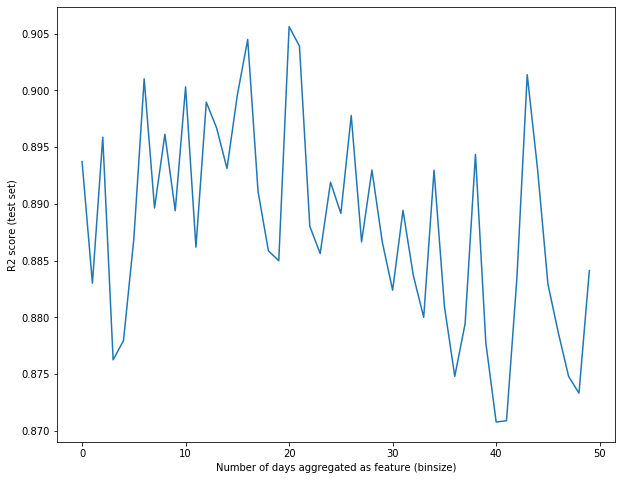

In [41]:
plt.plot(scores[:50])
plt.ylabel('R2 score (test set)')
plt.xlabel('Number of days aggregated as feature (binsize)')